In [7]:
import sys
sys.path.append('../_amigocloud')

from werkzeug.wrappers import Request, Response
from jinja2 import Template
from datetime import datetime, timedelta
import collections
from datetime import datetime

from amigocloud import AmigoCloud

In [8]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]

# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

In [9]:
ruta

'C:\\Documents\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

In [11]:
id=144

In [12]:
# DATOS DE LAS INPECCION
query = {'query': 'select CURRENT_DATE, * from dataset_292618 where id = {id}'.format(id=id)}
project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
select = amigocloud.get(project, query)
data = select['data'][0]
data['date'] = datetime.strptime(data['date'][0:10], '%Y-%m-%d').strftime('%d/%m/%Y')
data['fecha_quema'] = datetime.strptime(data['fecha_quema'][0:10], '%Y-%m-%d').strftime('%d/%m/%Y')
data['fecha_inspeccion'] = datetime.strptime(data['fecha_inspeccion'][0:10], '%Y-%m-%d').strftime('%d/%m/%Y')

insp = collections.namedtuple("insp", data.keys())(*data.values())
print('end')

end


In [13]:
insp

insp(date='24/10/2023', fecha_registro='2023-10-24 11:48:57+00:00', amigo_id='2872529c2beb4b2eb18d243d5c99a00f', fecha_quema='22/10/2023', fecha_inspeccion='23/10/2023', fecha_update='2023-10-24 11:48:57+00:00', canhero='13012 / SALAZAR ARNEZ LIDER', superficie_total=21.59, rendimiento=45.0, produccion=971.55, responsable='Rogelio Acuña Rodríguez', inicio_incendio='Dentro de la propiedad', causa='Quema de caña', responsable_de_quema='QUEMA DE CAÑA PARA COSECHA DENTRO DE LA MISMA PROPIEDAD', observaciones=None, link_informe=None, link_informe_editable=None, cite=479, link_comprobante=None, id=144, tipo_cosecha=None)

In [14]:
# DATOS DE LA PROPIEDAD
query = {'query': 'select * from dataset_293179 where insp_ref_prop = \'{insp_ref_prop}\''.format(insp_ref_prop=insp.amigo_id)}
project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
select = amigocloud.get(project, query)
propiedades_data = select['data']
print('end')

end


In [15]:
propiedades_data

[{'ubicacion': '0101000020E6100000DC8861308A8E4FC0A8F74FB5CD3B31C0',
  'amigo_id': '47be9c313b37407ea4ec7f6b840566b6',
  'fecha_registro': '2023-10-24 11:53:11+00:00',
  'fecha_update': '2023-10-24 11:53:11+00:00',
  'propiedad': '577 / SAN ANTONIO--IAG',
  'tenencia': 'Alquilado',
  'insp_ref_prop': '2872529c2beb4b2eb18d243d5c99a00f'}]

In [16]:
propiedades = []
for prop in propiedades_data:
    prop['lote'] = []
    query_lotes = {'query': 'select * from dataset_293180 where prop_ref_lote = \'{prop_ref_lote}\''.format(prop_ref_lote=prop['amigo_id'])}
    project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
    lotes_select = amigocloud.get(project, query_lotes)
    for lote_select in lotes_select['data']:
        lote = collections.namedtuple("lote", lote_select.keys())(*lote_select.values())
        prop['lote'].append(lote)
    propiedades.append(collections.namedtuple("propiedad", prop.keys())(*prop.values()))
print('end')

end


In [17]:
propiedades

[propiedad(ubicacion='0101000020E6100000DC8861308A8E4FC0A8F74FB5CD3B31C0', amigo_id='47be9c313b37407ea4ec7f6b840566b6', fecha_registro='2023-10-24 11:53:11+00:00', fecha_update='2023-10-24 11:53:11+00:00', propiedad='577 / SAN ANTONIO--IAG', tenencia='Alquilado', insp_ref_prop='2872529c2beb4b2eb18d243d5c99a00f', lote=[lote(geometria='0106000020E610000001000000010300000001000000090000002BB11E27C08E4FC05F6F35578B3B31C01DB11E4D7C8E4FC0F7D9223A723B31C001B11E896D8E4FC040910EB0833B31C0F5B01E51698E4FC0020454859A3B31C047B11E035D8E4FC0EF67C2478C3C31C049B11EADA38E4FC092083DD74F3C31C01FB11ED8968E4FC0DB1FE444013C31C057B11E2FC78E4FC0C8C3950CE33B31C02BB11E27C08E4FC05F6F35578B3B31C0', amigo_id='a05183a9d22b450d8091f9338e327264', fecha_registro='2023-10-24 11:56:11+00:00', fecha_update='2023-10-24 12:14:25.052164+00:00', lote='L6', superficie=9.9, observaciones=None, prop_ref_lote='47be9c313b37407ea4ec7f6b840566b6'), lote(geometria='0106000020E610000001000000010300000001000000040000005A5300A7588E4FC04

In [18]:
# selecciona todas las fotos y nombre de lotes basado en el id de la inspeccion
query_fotos = {'query': 'select l.lote, g.s3_filename file_name from gallery_42303 g\
                            inner join dataset_293180 l on l.amigo_id = g.source_amigo_id\
                            inner join dataset_293179 p on p.amigo_id = l.prop_ref_lote\
                            inner join dataset_292618 i on i.amigo_id = p.insp_ref_prop\
                            where i.id = {src_id}'.format(src_id=id)}
project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
select = amigocloud.get(project, query_fotos)
fotos = select['data']
fotos

[{'lote': 'L6', 'file_name': 'SALAZAR.png'}]

In [22]:
from shapely import wkb
import geopandas
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt

def convertir_wkb(wkb_data):
    return wkb.loads(wkb_data, hex=True)

In [23]:
ruta

'C:\\Documents\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

end


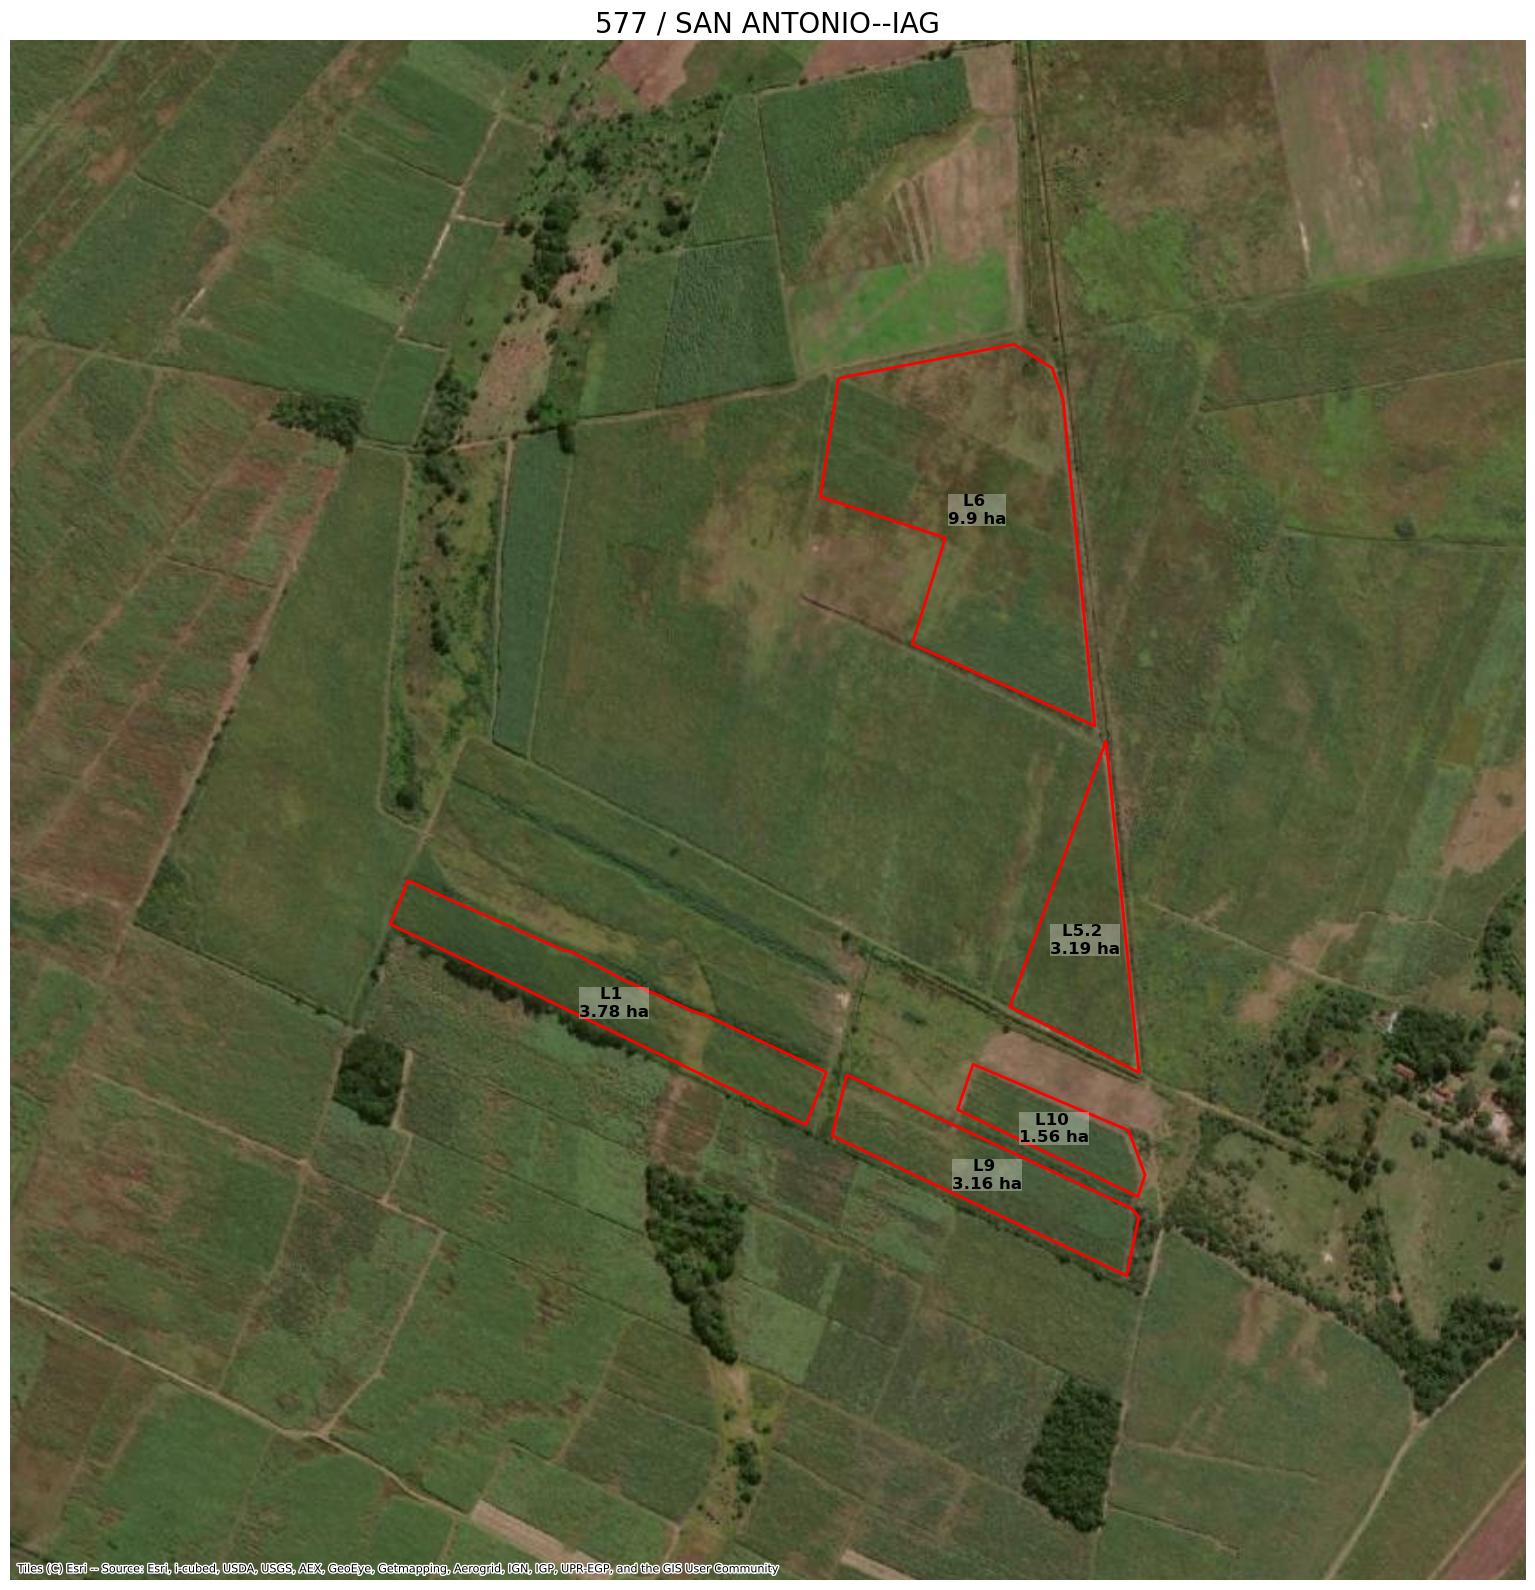

In [24]:
i = 0
lista_planos = []
path = ''
for propiedad in propiedades:
    i = i + 1
    lotes_lista = []
    for lote in propiedad.lote:
        lotes_lista.append(lote._asdict())
    df = pd.DataFrame(lotes_lista)
    df['geometria'] = df['geometria'].apply(convertir_wkb)

    #Convertir a GeoDataFrame
    data = geopandas.GeoDataFrame(df, geometry='geometria')
    #data
    #ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

    data['coords'] = data['geometria'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]

    data.crs = "EPSG:4326"
    data = data.to_crs(epsg=3857)

    
    fig = plt.figure(i, figsize=(20,20))
    #fig = plt.figure(1)
    ax = None
    ax = fig.add_subplot()

    #data.set_crs(epsg=4326, inplace=True)

    data.apply(lambda x: ax.annotate(text=x.lote + ' \n' + str(x.superficie) + ' ha', xy=x.geometria.centroid.coords[0], ha='center', va='center', color='black', fontsize=12, weight=1000, bbox=dict(facecolor=(1,1,1,0.3), edgecolor='none', pad=0)), axis=1);

    #data.boundary.plot(ax=ax, color=(0,0,0,0), linewidth=0)

    #data = data.to_crs(epsg=3857)

    minx, miny, maxx, maxy = data.total_bounds
    ax.set_xlim(minx - 500, maxx + 500)
    ax.set_ylim(miny - 400, maxy + 400)

    data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2, figsize=(20,20))
    #data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2)
    
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
    ax.set_axis_off()
    ax.set_title(str(propiedad.propiedad), fontsize=20)
    path = ruta + '/planos/' + str(insp.amigo_id) + '_' + str(propiedad.amigo_id) + '.jpeg'
    lista_planos.append(path)
    fig.savefig(path, dpi = 300, bbox_inches='tight')
    del fig
print('end')

In [25]:
from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm

import requests

doc = DocxTemplate(ruta + "/templates/tpl_infome_quema.docx")

#generar lista de InlineImage de planos 
lista_InlineImage = []
for plano in lista_planos:
    lista_InlineImage.append(docxtpl.InlineImage(doc, image_descriptor=plano, width=Mm(150)))

#descargar fotos y generar lista InlineImage
lista_fotos_inline = []
for foto in fotos:
    #response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
    response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
    file = open(ruta + '/fotos/' + foto['file_name'], "wb")
    file.write(response.content)
    file.close()
    lista_fotos_inline.append({'foto': docxtpl.InlineImage(doc, image_descriptor= ruta + '/fotos/' + foto['file_name'], width=Mm(120)), 'lote': foto['lote']})

firma_respon = None
if insp.responsable == 'Rogelio Acuña Rodríguez':
    firma_respon = docxtpl.InlineImage(doc, image_descriptor=ruta + '/templates/firma_rogelio.png', width=Mm(60))
else:
    firma_respon = docxtpl.InlineImage(doc, image_descriptor=ruta + '/templates/firma_jaldin.png', width=Mm(60))

context = {'insp':insp, 'propiedades':propiedades, 'planos':lista_InlineImage, 'fotos':lista_fotos_inline, 'firma':firma_respon}

doc.render(context)

# formato de nombre de archivo: "123_CQ_01-01-2022_NOMBRE"
cod_nom = insp.canhero.split(' / ')
file_name = cod_nom[0] + '_CAQ_' + insp.fecha_inspeccion.replace('/','-') + '_' + cod_nom[1] + '_' + str(insp.id)

doc.save(ruta + '/informes/_' + file_name + '.docx')